In [1]:
import pyreadr
import math
import numpy as np
import pandas as pd
from pymatreader import read_mat
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import matplotlib
import matplotlib.pyplot as plt
import time

In [2]:
def recursionStart(spectra):
    featurePairs = []
    maxima = []
    minima = []
    
    for i in range(1, len(spectra) - 1):
        if spectra[i] > spectra[i-1]:
            if spectra[i] >= spectra[i+1]:
                for j in range(i+1, len(spectra)):
                    if spectra[i] > spectra[j]:
                        maxima.append([i, spectra[i]])
                        break
                    elif spectra[i] < spectra[j]:
                        break
        if spectra[i] < spectra[i-1]:
            if spectra[i] <= spectra[i+1]:
                for j in range(i+1, len(spectra)):
                    if spectra[i] < spectra[j]:
                        minima.append([i, spectra[i]])
                        break
                    elif spectra[i] > spectra[j]:
                        break
    maxima.sort(key = lambda element: element[1], reverse = True)
    minima.sort(key = lambda element: element[1])
    
    globalMaxima = maxima.pop(0)
    featurePairs.append([globalMaxima[0], globalMaxima[1] - minima[0][1]])
    
    recursionStep(0, globalMaxima[0], maxima.copy(), minima.copy(), featurePairs)
    recursionStep(len(spectra) - 1, globalMaxima[0], maxima.copy(), minima.copy(), featurePairs)
    
    return featurePairs

def recursionStep(start, end, maxima, minima, featurePairs):
    factor = 1
    if end < start:
        factor = -1
    currentMaxima = []
    for i in range(len(maxima)):
        position = maxima[i][0]
        if start * factor < position * factor and position * factor < end * factor:
            currentMaxima.append(maxima[i])
    if len(currentMaxima) == 0:
        return
    localMaxima = currentMaxima.pop(0)
    recursionStep(start, localMaxima[0], currentMaxima.copy(), minima.copy(), featurePairs)
    currentMinima = []
    for i in range(len(minima)):
        position = minima[i][0]
        if localMaxima[0] * factor < position * factor and position * factor < end * factor:
            currentMinima.append(minima[i])
    localMinima = currentMinima.pop(0)
    featurePairs.append([localMaxima[0], localMaxima[1] - localMinima[1]])
    recursionStep(localMinima[0], localMaxima[0], currentMaxima.copy(), currentMinima.copy(), featurePairs)
    recursionStep(localMinima[0], end, currentMaxima.copy(), currentMinima.copy(), featurePairs)

In [3]:
def getPersistenceTransformation(data_X, listOfK):
    spectras = []
    for i in range(len(data_X)):
        featurePairs = recursionStart(data_X.iloc[i])
        featurePairs.sort(key = lambda element: element[1], reverse = True)
        spectras.append(featurePairs)
        
    spectrasForEachK = []
    
    for k in listOfK:
        transformationForSpectra = []
        for i in range(0, len(spectras)):
            transformation = [0] * len(data_X.iloc[i])
            featurePairs = spectras[i][0:round(k*len(spectras[i]))]
            for x, fx in featurePairs:
                transformation[x] = fx
            transformationForSpectra.append(transformation)
        spectrasForEachK.append(transformationForSpectra)
    return spectrasForEachK

In [4]:
def cvAccuracy(tmas, X, resp, classifier, ntrees = 150):
    
    tmas_names = ['TMA_1:', 'TMA_2:', 'TMA_3:', 'TMA_4:', 'TMA_5:', 'TMA_6:', 'TMA_7:', 'TMA_8:']
    
    tmas_res_test   = []
    tmas_vals_test  = []
    tmas_res_train  = []
    tmas_vals_train = []
    #WE fix this params in order to prevent from overfitting
    
    mtry =  round(math.sqrt(p))
    for tma in range(1, len(tmas_names)+1):
    
        X_train = X.iloc[tmas[tmas != tma].index, :]

        X_test = X.iloc[tmas[tmas == tma].index, :]

        y_train = resp.iloc[tmas[tmas != tma].index, :]

        y_test = resp.iloc[tmas[tmas == tma].index, :]
        
        if (classifier == 'logit'):

            np.random.seed(1234)
            
            logreg = LogisticRegression(penalty = None, solver = 'newton-cg',fit_intercept=True, random_state = 1234)

            logreg.fit(X_train, y_train.values.ravel())

            y_pred = logreg.predict_proba(X_test)

            y_pred_1 = np.where(y_pred[:, 1] > 0.5, 1, 0)

            accuracy = balanced_accuracy_score(y_test, y_pred_1)
            
            tmas_vals_test.append(accuracy)

            tmp_tmas = [tmas_names[tma-1], accuracy]

            tmas_res_test.append(tmp_tmas)
            
        if (classifier == 'rf'):
            
            rf = RandomForestClassifier(n_estimators= ntrees, random_state= 1234, criterion = 'gini',
                                        max_features=mtry)
            
            rf.fit(X_train, y_train.values.ravel())
            
            y_pred_rf = rf.predict(X_test)
            
            accuracy = balanced_accuracy_score(y_test, y_pred_rf)
            
            tmas_vals_test.append(accuracy)

            tmp_tmas = [tmas_names[tma-1], accuracy]

            tmas_res_test.append(tmp_tmas)
        
    return tmas_vals_test, tmas_res_test  

def Average(lst):
    return sum(lst) / len(lst)   

In [5]:
# Loading Data from Matlab
dataMaldi = read_mat('data/L1-8_tic_ad_sq.mat')

X_values = pd.DataFrame(dataMaldi['data_tic'])#Reading the mz-values 
                                #to get pd's as input for the ml
classes = pd.DataFrame(dataMaldi['classes'])#The cancer Typ, result for ml

mz_values = pd.DataFrame(dataMaldi['mzVector'])

TMAs   = pd.Series(dataMaldi['tmas'])

p = X_values.shape[0]

y = pd.DataFrame(np.where(classes == 1, 0, 1))

In [6]:
# We experiment over a grid of levels of peaks extraction. Namely, 0.01, 0.05, 0.1., 0.2, 0.3, 0.4, 0.5
listOfk = [0.01, 0.05, 0.1, 0.2, 0.25, 0.3, 0.4, 0.5]
st = time.time()
ListOfXk = getPersistenceTransformation(data_X = X_values, listOfK = listOfk)
et = time.time()
print('Time for the processing: ', et-st)
X_k0 = ListOfXk[0]
X_k1 = ListOfXk[1]
X_k2 = ListOfXk[2]
X_k3 = ListOfXk[3]
X_k4 = ListOfXk[4]
X_k5 = ListOfXk[5]
X_k6 = ListOfXk[6]
X_k7 = ListOfXk[7]

Time for the processing:  252.0769019126892


In [7]:
st0 = time.time()
res_k0_1, res_k0_2 = cvAccuracy(tmas =TMAs, resp=y, X = pd.DataFrame(X_k0), classifier = 'logit')
et0 = time.time()
print('Time for processing ', listOfk[0], ': ', et0 - st0)
st1 = time.time()
res_k1_1, res_k1_2 = cvAccuracy(tmas =TMAs, resp=y, X = pd.DataFrame(X_k1), classifier = 'logit')
et1 = time.time()
print('Time for processing ', listOfk[1], ': ', et1 - st1)
st2 = time.time()
res_k2_1, res_k2_2 = cvAccuracy(tmas =TMAs, resp=y, X = pd.DataFrame(X_k2), classifier = 'logit')
et2 = time.time()
print('Time for processing ', listOfk[2], ': ', et2 - st2)
st3 = time.time()
res_k3_1, res_k3_2 = cvAccuracy(tmas =TMAs, resp=y, X = pd.DataFrame(X_k3), classifier = 'logit')
et3 = time.time()
print('Time for processing ', listOfk[3], ': ', et3 - st3)
st4 = time.time()
res_k4_1, res_k4_2 = cvAccuracy(tmas =TMAs, resp=y, X = pd.DataFrame(X_k4), classifier = 'logit')
et4 = time.time()
print('Time for processing ', listOfk[4], ': ', et4 - st4)
st5 = time.time()
res_k5_1, res_k5_2 = cvAccuracy(tmas =TMAs, resp=y, X = pd.DataFrame(X_k5), classifier = 'logit')
et5 = time.time()
print('Time for processing ', listOfk[5], ': ', et5 - st5)
st6 = time.time()
res_k6_1, res_k6_2 = cvAccuracy(tmas =TMAs, resp=y, X = pd.DataFrame(X_k6), classifier = 'logit')
et6 = time.time()
print('Time for processing ', listOfk[6], ': ', et6 - st6)
st7 = time.time()
res_k7_1, res_k7_2 = cvAccuracy(tmas =TMAs, resp=y, X = pd.DataFrame(X_k7), classifier = 'logit')
et7 = time.time()
print('Time for processing ', listOfk[7], ': ', et7 - st7)
st8 = time.time()
q1, q2 = cvAccuracy(tmas =TMAs, resp=y, X = X_values, classifier='logit')
et8 = time.time()
print('Time for processing the raw data: ', et8 - st8)

Time for processing  0.01 :  84.78022789955139
Time for processing  0.05 :  126.31110572814941
Time for processing  0.1 :  39.76270866394043
Time for processing  0.2 :  35.18696093559265
Time for processing  0.25 :  34.73161959648132
Time for processing  0.3 :  31.414316654205322
Time for processing  0.4 :  28.716187477111816
Time for processing  0.5 :  26.255290269851685
Time for processing the raw data:  22.590450048446655


In [8]:
st0 = time.time()
rf_k0_1, rf_k0_2 = cvAccuracy(tmas =TMAs, resp=y, X = pd.DataFrame(X_k0), classifier = 'rf', ntrees = 500)
et0 = time.time()
print('Time for processing ', listOfk[0], ': ', et0 - st0)
st1 = time.time()
rf_k1_1, rf_k1_2 = cvAccuracy(tmas =TMAs, resp=y, X = pd.DataFrame(X_k1), classifier = 'rf', ntrees = 500)
et1 = time.time()
print('Time for processing ', listOfk[1], ': ', et1 - st1)
st2 = time.time()
rf_k2_1, rf_k2_2 = cvAccuracy(tmas =TMAs, resp=y, X = pd.DataFrame(X_k2), classifier = 'rf', ntrees = 500)
et2 = time.time()
print('Time for processing ', listOfk[2], ': ', et2 - st2)
st3 = time.time()
rf_k3_1, rf_k3_2 = cvAccuracy(tmas =TMAs, resp=y, X = pd.DataFrame(X_k3), classifier = 'rf', ntrees = 500)
et3 = time.time()
print('Time for processing ', listOfk[3], ': ', et3 - st3)
st4 = time.time()
rf_k4_1, rf_k4_2 = cvAccuracy(tmas =TMAs, resp=y, X = pd.DataFrame(X_k4), classifier = 'rf', ntrees = 500)
et4 = time.time()
print('Time for processing ', listOfk[4], ': ', et4 - st4)
st5 = time.time()
rf_k5_1, rf_k5_2 = cvAccuracy(tmas =TMAs, resp=y, X = pd.DataFrame(X_k5), classifier = 'rf', ntrees = 500)
et5 = time.time()
print('Time for processing ', listOfk[5], ': ', et5 - st5)
st6 = time.time()
rf_k6_1, rf_k6_2 = cvAccuracy(tmas =TMAs, resp=y, X = pd.DataFrame(X_k6), classifier = 'rf', ntrees = 500)
et6 = time.time()
print('Time for processing ', listOfk[6], ': ', et6 - st6)
st7 = time.time()
rf_k7_1, rf_k7_2 = cvAccuracy(tmas =TMAs, resp=y, X = pd.DataFrame(X_k7), classifier = 'rf', ntrees = 500)
et7 = time.time()
print('Time for processing ', listOfk[7], ': ', et7 - st7)
st8 = time.time()
rf_raw_1, rf_raw_2 = cvAccuracy(tmas =TMAs, resp=y, X = X_values, classifier='rf', ntrees = 500)
et8 = time.time()
print('Time for processing the raw data: ', et8 - st8)


Time for processing  0.01 :  90.0447449684143
Time for processing  0.05 :  82.07766890525818
Time for processing  0.1 :  103.25165009498596
Time for processing  0.2 :  152.64710426330566
Time for processing  0.25 :  173.2867636680603
Time for processing  0.3 :  195.8485724925995
Time for processing  0.4 :  235.72318816184998
Time for processing  0.5 :  270.473393201828
Time for processing the raw data:  1002.0702612400055


In [9]:
st0 = time.time()
rf_k0_1000, rf_k0_2_1000= cvAccuracy(tmas =TMAs, resp=y, X = pd.DataFrame(X_k0), classifier = 'rf', ntrees = 1000)
et0 = time.time()
print('Time for processing ', listOfk[0], ': ', et0 - st0)
st1 = time.time()
rf_k1_1000, rf_k1_2_1000 = cvAccuracy(tmas =TMAs, resp=y, X = pd.DataFrame(X_k1), classifier = 'rf', ntrees = 1000)
et1 = time.time()
print('Time for processing ', listOfk[1], ': ', et1 - st1)
st2 = time.time()
rf_k2_1000, rf_k2_2_1000 = cvAccuracy(tmas =TMAs, resp=y, X = pd.DataFrame(X_k2), classifier = 'rf', ntrees = 1000)
et2 = time.time()
print('Time for processing ', listOfk[2], ': ', et2 - st2)
st3 = time.time()
rf_k3_1000, rf_k3_2_1000 = cvAccuracy(tmas =TMAs, resp=y, X = pd.DataFrame(X_k3), classifier = 'rf', ntrees = 1000)
et3 = time.time()
print('Time for processing ', listOfk[3], ': ', et3 - st3)
st4 = time.time()
rf_k4_1000, rf_k4_2_1000 = cvAccuracy(tmas =TMAs, resp=y, X = pd.DataFrame(X_k4), classifier = 'rf', ntrees = 1000)
et4 = time.time()
print('Time for processing ', listOfk[4], ': ', et4 - st4)
st5 = time.time()
rf_k5_1000, rf_k5_2_1000 = cvAccuracy(tmas =TMAs, resp=y, X = pd.DataFrame(X_k5), classifier = 'rf', ntrees = 1000)
et5 = time.time()
print('Time for processing ', listOfk[5], ': ', et5 - st5)
st6 = time.time()
rf_k6_1000, rf_k6_2_1000 = cvAccuracy(tmas =TMAs, resp=y, X = pd.DataFrame(X_k6), classifier = 'rf', ntrees = 1000)
et6 = time.time()
print('Time for processing ', listOfk[6], ': ', et6 - st6)
st7 = time.time()
rf_k7_1000, rf_k7_2_1000 = cvAccuracy(tmas =TMAs, resp=y, X = pd.DataFrame(X_k7), classifier = 'rf', ntrees = 1000)
et7 = time.time()
print('Time for processing ', listOfk[7], ': ', et7 - st7)
st8 = time.time()
rf_raw_1000, rf_raw_2_1000 = cvAccuracy(tmas =TMAs, resp=y, X = X_values, classifier='rf', ntrees = 1000)
et8 = time.time()
print('Time for processing the raw data: ', et8 - st8)

Time for processing  0.01 :  179.07954835891724
Time for processing  0.05 :  161.40385961532593
Time for processing  0.1 :  204.03130269050598
Time for processing  0.2 :  304.1930558681488
Time for processing  0.25 :  345.4050121307373
Time for processing  0.3 :  387.91496562957764
Time for processing  0.4 :  462.8657660484314
Time for processing  0.5 :  536.0606205463409
Time for processing the raw data:  2007.0446529388428


In [10]:
results_as_tables = pd.concat([pd.DataFrame(res_k0_1).describe(), pd.DataFrame(res_k1_1).describe(),
                              pd.DataFrame(res_k2_1).describe(), pd.DataFrame(res_k3_1).describe(),
                              pd.DataFrame(res_k4_1).describe(), pd.DataFrame(res_k5_1).describe(),
                              pd.DataFrame(res_k6_1).describe(), pd.DataFrame(res_k7_1).describe(),
                               pd.DataFrame(q1).describe()],
                              axis=1)
results_to_latex = round(results_as_tables, 3)

results_to_latex = results_to_latex.set_axis(['k = 0.01', 'k = 0.05', ' k = 0.1', 'k = 0.2', 
                           'k = 0.25', 'k = 0.3', 'k = 0.4', 'k = 0.5', 'raw'], axis=1)

#pd.DataFrame(results_to_latex).style.to_latex('results/logit_results.tex')

In [11]:
results_to_latex

,k = 0.01,k = 0.05,k = 0.1,k = 0.2,k = 0.25,k = 0.3,k = 0.4,k = 0.5,raw
count,8.000,8.000,8.000,8.000,8.000,8.000,8.000,8.000,8.000
mean,0.631,0.735,0.826,0.845,0.859,0.866,0.859,0.859,0.871
std,0.108,0.091,0.074,0.079,0.077,0.076,0.076,0.078,0.075
min,0.461,0.630,0.722,0.716,0.724,0.743,0.737,0.723,0.718
25%,0.576,0.652,0.769,0.795,0.820,0.809,0.812,0.826,0.849
50%,0.634,0.723,0.827,0.869,0.886,0.888,0.880,0.878,0.891
75%,0.699,0.829,0.881,0.903,0.918,0.923,0.924,0.921,0.922
max,0.792,0.849,0.917,0.937,0.931,0.950,0.935,0.935,0.941


In [12]:
results_as_tables_rf_500 = pd.concat([pd.DataFrame(rf_k0_1).describe(),
                              pd.DataFrame(rf_k1_1).describe(), pd.DataFrame(rf_k2_1).describe(),
                              pd.DataFrame(rf_k3_1).describe(), pd.DataFrame(rf_k4_1).describe(),
                              pd.DataFrame(rf_k5_1).describe(), pd.DataFrame(rf_k6_1).describe(), 
                              pd.DataFrame(rf_k7_1).describe(), pd.DataFrame(rf_raw_1).describe()],
                              axis=1)

results_rf_to_latex_500 = round(results_as_tables_rf_500, 3)

results_rf_to_latex_500 = results_rf_to_latex_500.set_axis(['k = 0.01', 'k = 0.05', ' k = 0.1', 'k = 0.2', 
                           'k = 0.25', 'k = 0.3' ,'k = 0.4', 'k = 0.5', 'raw'], axis=1)

#pd.DataFrame(results_rf_to_latex).style.to_latex('results/results_rf_to_latex.tex')

In [13]:
results_rf_to_latex_500

,k = 0.01,k = 0.05,k = 0.1,k = 0.2,k = 0.25,k = 0.3,k = 0.4,k = 0.5,raw
count,8.000,8.000,8.000,8.000,8.000,8.000,8.000,8.000,8.000
mean,0.643,0.785,0.838,0.863,0.871,0.874,0.871,0.869,0.872
std,0.107,0.091,0.085,0.073,0.074,0.070,0.070,0.074,0.065
min,0.519,0.646,0.694,0.745,0.749,0.756,0.758,0.748,0.775
25%,0.573,0.705,0.797,0.827,0.835,0.846,0.833,0.830,0.828
50%,0.619,0.830,0.852,0.865,0.883,0.893,0.897,0.896,0.885
75%,0.709,0.848,0.897,0.924,0.923,0.923,0.925,0.927,0.928
max,0.831,0.880,0.931,0.945,0.964,0.948,0.936,0.934,0.939


In [14]:
results_as_tables_rf_1000 = pd.concat([pd.DataFrame(rf_k0_1000).describe(),
                              pd.DataFrame(rf_k1_1000).describe(), pd.DataFrame(rf_k2_1000).describe(),
                              pd.DataFrame(rf_k3_1000).describe(), pd.DataFrame(rf_k4_1000).describe(),
                              pd.DataFrame(rf_k5_1000).describe(), pd.DataFrame(rf_k6_1000).describe(), 
                              pd.DataFrame(rf_k7_1000).describe(), pd.DataFrame(rf_raw_1000).describe()],
                              axis=1)

results_rf_to_latex_1000 = round(results_as_tables_rf_1000, 3)

results_rf_to_latex_1000 = results_rf_to_latex_1000.set_axis(['k = 0.01', 'k = 0.05', ' k = 0.1', 'k = 0.2', 
                           'k = 0.25', 'k = 0.3' ,'k = 0.4', 'k = 0.5', 'raw'], axis=1)

#pd.DataFrame(results_rf_to_latex).style.to_latex('results/results_rf_to_latex.tex')

In [15]:
results_rf_to_latex_1000

,k = 0.01,k = 0.05,k = 0.1,k = 0.2,k = 0.25,k = 0.3,k = 0.4,k = 0.5,raw
count,8.000,8.000,8.000,8.000,8.000,8.000,8.000,8.000,8.000
mean,0.648,0.789,0.834,0.862,0.870,0.877,0.870,0.869,0.875
std,0.109,0.089,0.089,0.073,0.078,0.064,0.066,0.071,0.060
min,0.519,0.650,0.689,0.747,0.745,0.769,0.771,0.758,0.779
25%,0.578,0.706,0.777,0.821,0.831,0.846,0.835,0.830,0.840
50%,0.625,0.829,0.855,0.865,0.884,0.891,0.884,0.891,0.886
75%,0.708,0.852,0.896,0.920,0.926,0.925,0.924,0.925,0.923
max,0.845,0.884,0.931,0.945,0.959,0.947,0.938,0.934,0.936


In [16]:
mtry = round(math.sqrt(X_values.shape[0]))

feature_importance_best_model = RandomForestClassifier(n_estimators= 1000, random_state= 1234, criterion = 'gini',
                                        max_features=mtry)

st = time.time()
feature_importance_best_model.fit(pd.DataFrame(X_k5), y.values.ravel())
et = time.time()
print('Time for processing the raw data: ', et - st)

Time for processing the raw data:  61.19987940788269


In [17]:
mtry = round(math.sqrt(X_values.shape[0]))

feature_importance_raw = RandomForestClassifier(n_estimators= 1000, random_state= 1234, criterion = 'gini',
                                        max_features=mtry)

st = time.time()
feature_importance_raw.fit(pd.DataFrame(X_values), y.values.ravel())
et = time.time()

print('Time for processing the raw data: ', et - st)

Time for processing the raw data:  298.6029953956604


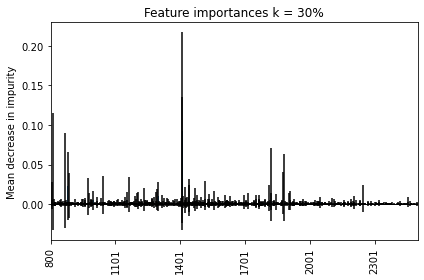

In [18]:
importances = feature_importance_best_model.feature_importances_
forest_importances = pd.Series(importances)
std = np.std([tree.feature_importances_ for tree in feature_importance_best_model.estimators_], axis=0)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax= ax)
plt.xticks(np.arange(len(mz_values))[::300].round(), labels= (mz_values.to_numpy()[:,0][::300].round().astype(int)))

ax.set_title("Feature importances k = 30%")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [19]:
best_mod_impt = pd.DataFrame(dataMaldi['mzVector'])

best_mod_impt['imp'] = importances

pd.DataFrame(best_mod_impt)

best_mod_impt = best_mod_impt.sort_values(by='imp', ascending=False)

#best_mod_impt[:30]

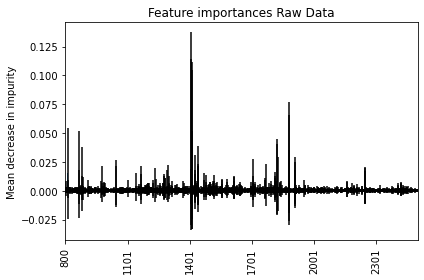

In [20]:
importances_raw = feature_importance_raw.feature_importances_

forest_importances_raw = pd.Series(importances_raw)

std = np.std([tree.feature_importances_ for tree in feature_importance_raw.estimators_], axis=0)

fig, ax = plt.subplots()
forest_importances_raw.plot.bar(yerr=std, ax= ax)
plt.xticks(np.arange(len(mz_values))[::300].round(), labels= (mz_values.to_numpy()[:,0][::300].round().astype(int)))

ax.set_title("Feature importances Raw Data")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

<Figure size 900x900 with 0 Axes>

<Figure size 432x288 with 0 Axes>

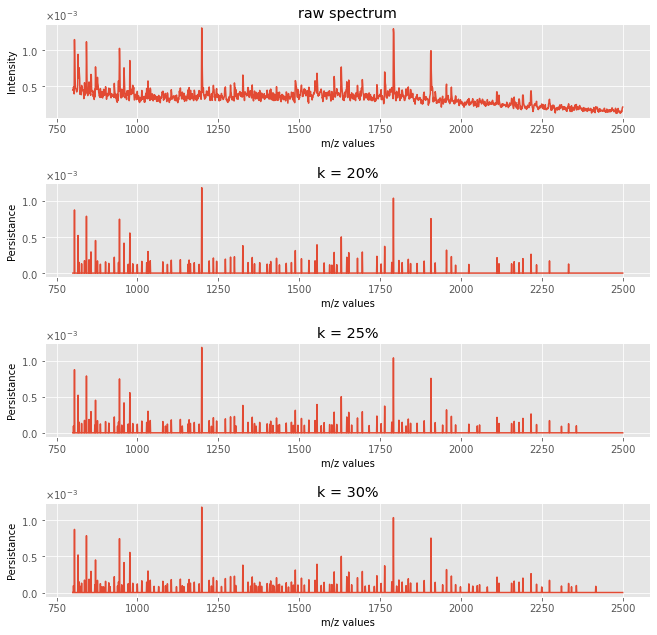

In [21]:
matplotlib.style.use('ggplot')

#[0.01, 0.05, 0.1, 0.2, 0.25, 0.3, 0.4, 0.5]
fig = plt.figure(figsize=(3, 3), dpi=300)

#plt.subplot(1, 2, 1)

s1 = X_values.loc[[22]]
s2 = pd.DataFrame(X_k3).loc[[22]]
s3 = pd.DataFrame(X_k4).loc[[22]]
s4 = pd.DataFrame(X_k5).loc[[22]]

fig = plt.figure()

fig, ax = plt.subplots(4, 1)


ax[0].plot(mz_values, np.transpose(s1))

ax[0].ticklabel_format(axis='y',style='sci',scilimits=(-3, -3), useMathText = True)
ax[0].set_ylabel('Intensity')
ax[0].set_xlabel('m/z values')
ax[0].set_title("raw spectrum")

#.subplot(2, 2, 2) # index 2
ax[1].plot(mz_values, np.transpose(s2))
ax[1].ticklabel_format(axis='y',style='sci',scilimits=(-3, -3), useMathText = True)
ax[1].set_ylabel('Persistance')
ax[1].set_xlabel('m/z values')
ax[1].set_title("k = 20%")

ax[2].plot(mz_values, np.transpose(s3))
ax[2].ticklabel_format(axis='y',style='sci',scilimits=(-3, -3), useMathText = True)
ax[2].set_ylabel('Persistance')
ax[2].set_xlabel('m/z values')
ax[2].set_title("k = 25%")

ax[3].plot(mz_values, np.transpose(s4))
ax[3].ticklabel_format(axis='y',style='sci',scilimits=(-3, -3), useMathText = True)
ax[3].set_ylabel('Persistance')
ax[3].set_xlabel('m/z values')
ax[3].set_title("k = 30%")

plt.subplots_adjust(left=0.1,
                    bottom=0.01,
                    right=1.5,
                    top=2,
                    wspace=0.6,
                    hspace=0.7)

#plt.savefig("results/Figure6.pdf", format="pdf", bbox_inches="tight")



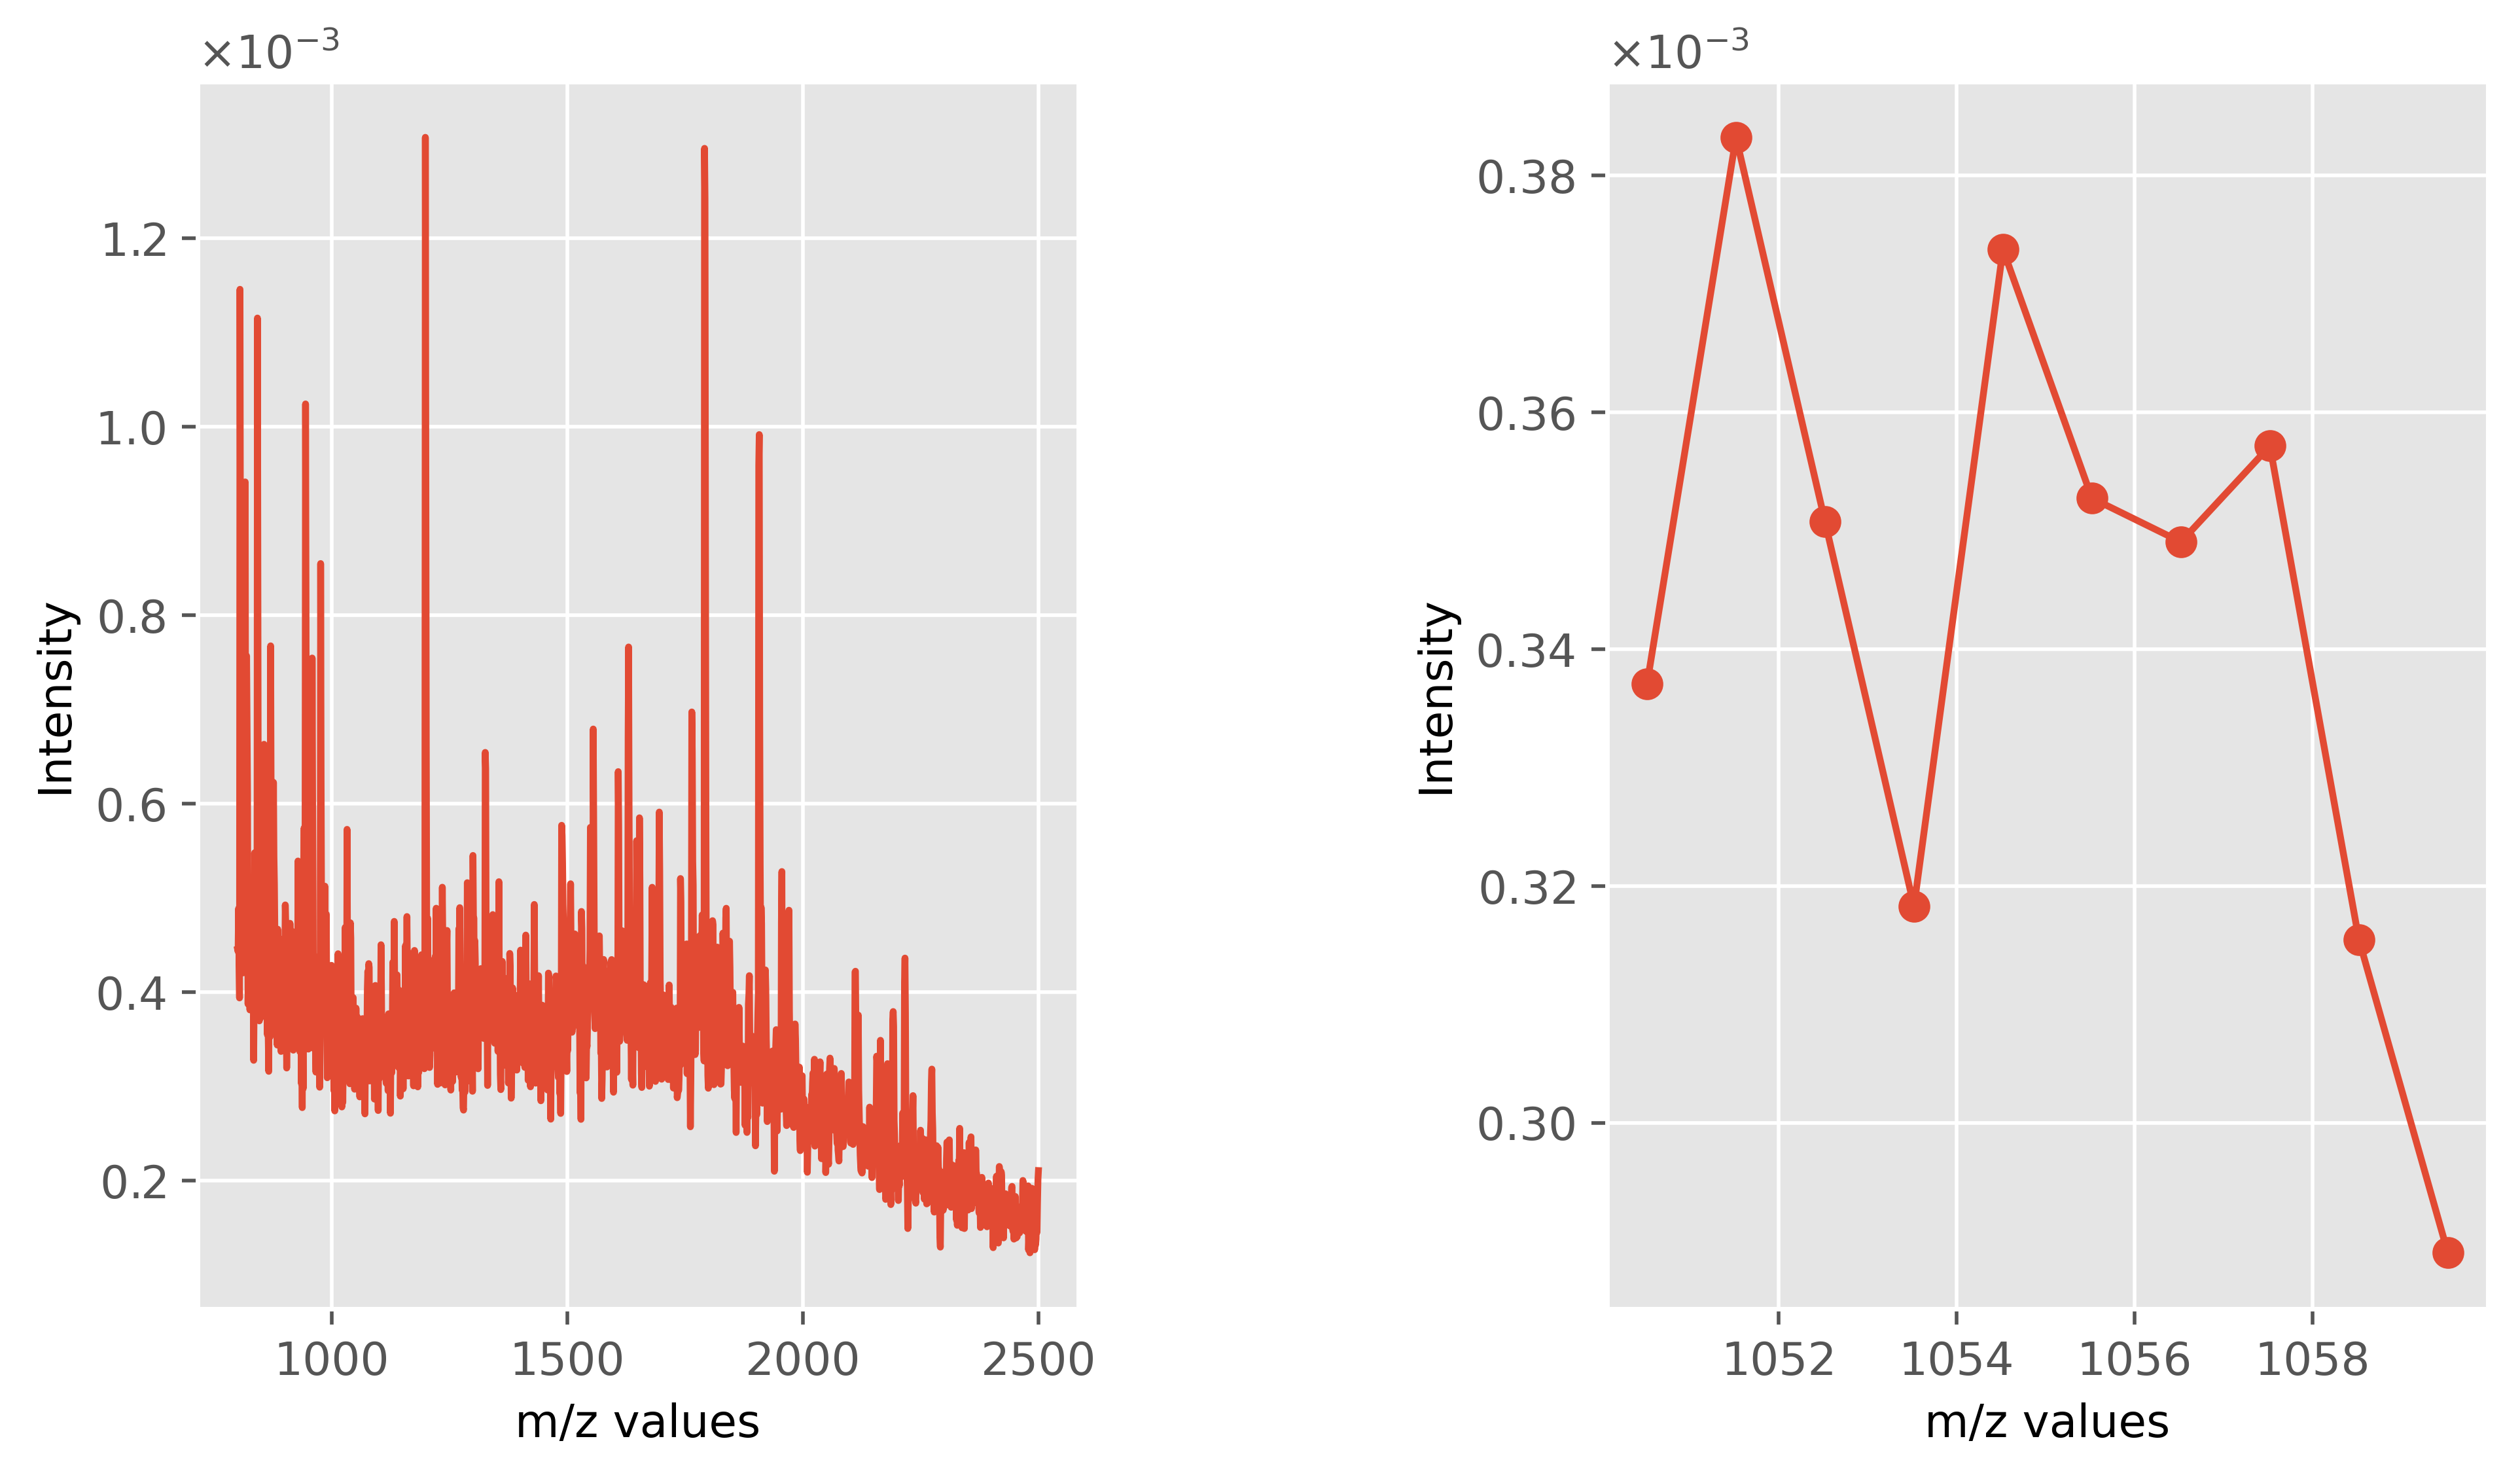

In [22]:
import matplotlib
matplotlib.style.use('ggplot')
s1 = X_values.loc[[22]]

fig = plt.figure(figsize=(5,5), dpi=500)

plt.subplot(1, 2, 1)
plt.plot(mz_values, np.transpose( X_values.loc[[22]]))
plt.ylabel('Intensity')
plt.xlabel('m/z values')

plt.ticklabel_format(axis='y',style='sci',scilimits=(-3, -3), useMathText = True)

plt.subplot(1, 2, 2) # index 2
plt.plot(mz_values[250:260], np.transpose( X_values.loc[[22]])[250:260], marker = 'o')
plt.ylabel('Intensity')
plt.xlabel('m/z values')


plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=1.5,
                    top=0.85,
                    wspace=0.6,
                    hspace=0.4)

plt.ticklabel_format(axis='y',style='sci',scilimits=(-3, -3), useMathText = True)

#plt.savefig("results/Figure5.pdf", format="pdf", bbox_inches="tight")